#### Dynamo SSA data

In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import linregress

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [2]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/')
data = xr.open_dataset('dynamo_ssa_v3a.nc')
omega_s = data.omega
div_s = data.div
q_s = data.wmr
hq_s = data.hq
qvflux_s = hq_s*1e-3 + q_s*1e-3*div_s*1e-6

data = xr.open_dataset('dynamo_nsa_v3a.nc')
omega_n = data.omega
div_n = data.div
q_n = data.wmr
hq_n = data.hq
qvflux_n = hq_n*1e-3 + q_n*1e-3*div_n*1e-6

lev = omega_s.level

In [3]:
data = np.loadtxt('/data/willytsai/ISCCP/dynamo_ssa/TRMM/TRMM_rainfall')
prec_s = data[:,2] # ssa, TRMM prec [mm/day]
prec_n = data[:,1] # nsa, TRMM prec [mm/day]

In [14]:
# define events by prec
date = omega_s.time
t_event_s = []

t_all = np.where(prec_s>5)[0] # averaged rainfall > 5 mm/day
t_all = t_all[np.logical_and(t_all > 16,t_all < len(date)-17)] 
for t in t_all:
    p_window = prec_s[t-16:t+17]
    if p_window.max() == p_window[16]: # prec max within 3d
        t_event_s.append(t)        
t_event_s = np.asarray(t_event_s)

date = omega_n.time
t_event_n = []

t_all = np.where(prec_n>5)[0] # averaged rainfall > 5 mm/day
t_all = t_all[np.logical_and(t_all > 16,t_all < len(date)-17)] 
for t in t_all:
    p_window = prec_n[t-16:t+17]
    if p_window.max() == p_window[16]: # prec max within 3d
        t_event_n.append(t)        
t_event_n = np.asarray(t_event_n)

In [15]:
print(t_event_s)
print(t_event_n)

[ 40  90 114 142 215 275 311 368 402 435 466 496 537 611 650 679 711]
[ 95 120 143 170 231 263 322 383 405 438 458 544 617 654]


In [16]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/gridsat_BT/remap_0.1deg/2011')
files = glob('*.nc')
bt_s = np.zeros(len(q_s.time))
cldfrac_s = np.copy(bt_s)
bt_n = np.copy(bt_s)
cldfrac_n = np.copy(bt_s)

for n,file in enumerate(files):
    data = xr.open_dataset(file)
    tmp = data.irwin_cdr.sel(lat=slice(-8,0),lon=slice(72,80)) # ssa region
    tmp2 = data.irwin_cdr.sel(lat=slice(-1,7),lon=slice(73,81))
    
    bt_s[n] = tmp.mean(axis=(0,1))
    cldfrac_s[n] = len(np.where(tmp<240)[0])/(tmp.shape[0]*tmp.shape[1])
    
    bt_n[n] = tmp2.mean(axis=(0,1))
    cldfrac_n[n] = len(np.where(tmp2<240)[0])/(tmp2.shape[0]*tmp.shape[1])

(0, 735)

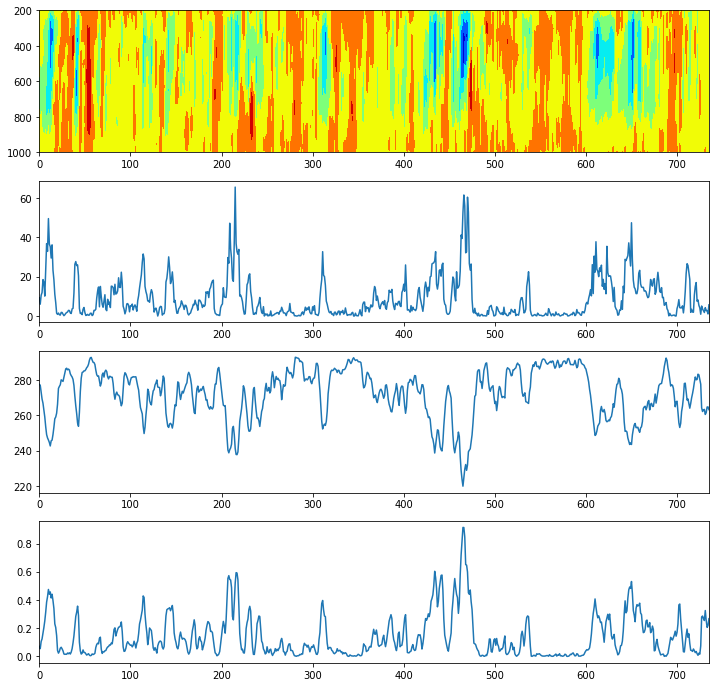

In [17]:
fig,ax = plt.subplots(4,1,figsize=(12,12))
cf = ax[0].contourf(range(len(omega_s.time)),lev,omega_s.T,cmap='jet')
#cbar = plt.colorbar(cf,ax=ax[0])
ax[0].set_ylim([1000,200]);ax[0].set_xlim([0,735])
ax[1].plot(range(len(omega_s.time)),prec_s)
ax[1].set_xlim([0,735])
ax[2].plot(range(len(omega_s.time)),bt_s)
ax[2].set_xlim([0,735])
ax[3].plot(range(len(omega_s.time)),cldfrac_s)
ax[3].set_xlim([0,735])

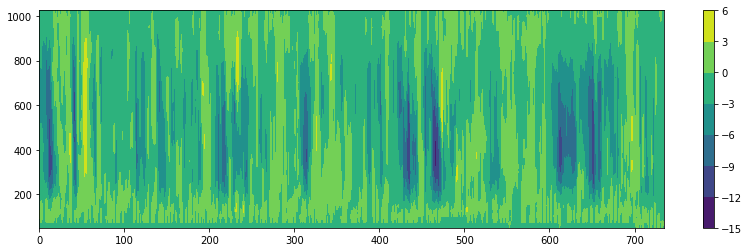

In [18]:
fig = plt.figure(figsize=(14,4))
plt.contourf(range(len(omega_s.time)),lev,omega_s.T)
plt.colorbar()

In [19]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='^', color='w', label='DYNAMO_NSA',markeredgecolor='b',
                          markerfacecolor='w', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='DYNAMO_SSA',markeredgecolor='r',
                          markerfacecolor='w', markersize=7),]

In [20]:
cldfrac_case = np.concatenate([cldfrac_n[t_event_n],cldfrac_s[t_event_s]])
qvflux_case = np.concatenate([qvflux_n[t_event_n],qvflux_s[t_event_s]])
TRMM_case = np.concatenate([prec_n[t_event_n],prec_s[t_event_s]])

In [21]:
# linear regression 
a = linregress(cldfrac_case,-qvflux_case[:,17]*86400) # 600hpa qvflux convergence
slope = a.slope
interp = a.intercept
r_val = a.rvalue

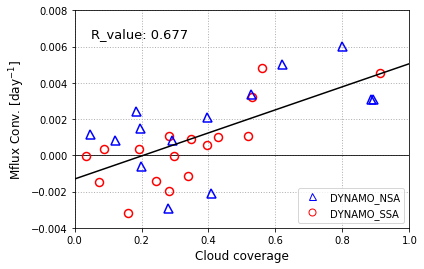

In [22]:
# Mflux at 600hpa bined by cloudfraction
fig = plt.figure()
for t1 in t_event_s:
    plt.plot(cldfrac_s[t1],-qvflux_s[t1,17]*86400,'o',color='r',markersize=8
             ,markerfacecolor='None',mew=1.5)
for t2 in t_event_n:
    plt.plot(cldfrac_n[t2],-qvflux_n[t2,17]*86400,'^',color='b'
             ,markersize=9,markerfacecolor='None',mew=1.5)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100)*slope+interp,'k')
plt.hlines(y=0,xmin=0,xmax=1,linewidth=0.8)
plt.ylabel('Mflux Conv. [day$^{-1}]$',fontsize=12)
plt.legend(handles=legend_elements, loc=4)
plt.text(0.05,6.5e-3,'R_value: '+str(round(r_val,3)),fontsize=13,color='k')
plt.xlim([0,1]);plt.xlabel('Cloud coverage',fontsize=12)
plt.ylim([-0.004,0.008])
plt.grid(linewidth=1,linestyle=':')

fig.savefig('/data/willytsai/ISCCP/fig/Mflux600hpa_CF_Dynamo.pdf',bbox_inches='tight')

In [23]:
## vertical velocity
omega_case = np.concatenate([omega_n[t_event_n],omega_s[t_event_s]])

In [24]:
prec_case = np.tile(TRMM_case,(40,1)).swapaxes(0,1) # for rescale omega by TRMM precip mm/day

In [25]:
cf_bins = np.linspace(0,1,6)
omega_com = np.zeros((len(cf_bins)-1,40))
omega_comstd = np.copy(omega_com)

for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_case>=cf_bins[n],cldfrac_case<cf_bins[n+1]))[0]
    omega_com[n,:] = np.nanmean(omega_case[idx,:],axis=0)/np.nanmean(prec_case[idx,:],axis=0)
    print(len(idx),prec_case[idx,0])
    omega_comstd[n,:] = np.nanstd(omega_case[idx,:],axis=0)/np.sqrt(len(idx))

10 [ 7.9077 30.2925 19.2197 15.4015 16.3747  6.3686 15.0081  5.4264 22.2318
 26.5983]
10 [22.0826 12.6266 45.2554 27.6846 22.2804 30.0774 32.7169 25.9679 22.5006
 37.7638]
6 [49.4564 20.958  31.5429 65.5483 32.7329 47.4225]
1 [44.7526]
4 [113.1596  46.8703 100.106   61.5418]


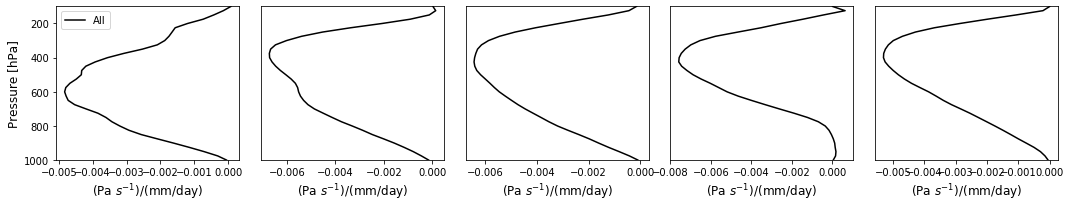

In [26]:
fig,ax = plt.subplots(1,5,figsize=(15,3))
for n in range(5):
    ax[n].plot(omega_com[n,:]/3600*100,lev,'-k') # (pa/s)/(mm/day)
    ax[n].set_yticks([])
    if n == 0:
        ax[n].set_yticks([1000,800,600,400,200])
        ax[n].set_ylabel('Pressure [hPa]',fontsize=12)
        ax[n].legend(['All'])
    ax[n].set_ylim([1000,100]);#ax[n].set_xlim([-0.04,0.02])
    ax[n].set_xlabel('(Pa $s^{-1}$)/(mm/day)',fontsize=12)
plt.tight_layout(w_pad=0.06)

In [27]:
os.chdir('/data/willytsai/ISCCP')
np.save('omega_grouped_Dynamo_rescale_4ds.mat.npy',omega_com)